In [1]:
using AdvancedHMC, Distributions, ForwardDiff
using LinearAlgebra

In [2]:
# Choose parameter dimensionality and initial parameter value
D = 10; initial_θ = rand(D)

# Define the target distribution
ℓπ(θ) = logpdf(MvNormal(zeros(D), I), θ)

# Set the number of samples to draw and warmup iterations
n_samples, n_adapts = 2_000, 1_000

# Define a Hamiltonian system
metric = DiagEuclideanMetric(D)
hamiltonian = Hamiltonian(metric, ℓπ, ForwardDiff)

# Define a leapfrog solver, with initial step size chosen heuristically
initial_ϵ = find_good_stepsize(hamiltonian, initial_θ)
integrator = Leapfrog(initial_ϵ)

# Define an HMC sampler, with the following components
#   - multinomial sampling scheme,
#   - generalised No-U-Turn criteria, and
#   - windowed adaption for step-size and diagonal mass matrix
proposal = NUTS{MultinomialTS, GeneralisedNoUTurn}(integrator)
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.8, integrator))

StanHMCAdaptor(
    pc=WelfordVar,
    ssa=NesterovDualAveraging(γ=0.05, t_0=10.0, κ=0.75, δ=0.8, state.ϵ=1.6),
    init_buffer=75, term_buffer=50, window_size=25,
    state=window(0, 0), window_splits()
)

In [4]:
# Run the sampler to draw samples from the specified Gaussian, where
#   - `samples` will store the samples
#   - `stats` will store diagnostic statistics for each sample
samples, stats = sample(hamiltonian, proposal, initial_θ, n_samples, adaptor, n_adapts; progress=true);

┌ Warning: ProgressMeter by default refresh meters with additional information in IJulia via `IJulia.clear_output`, which clears all outputs in the cell. 
│  - To prevent this behaviour, do `ProgressMeter.ijulia_behavior(:append)`. 
│  - To disable this warning message, do `ProgressMeter.ijulia_behavior(:clear)`.
└ @ ProgressMeter C:\Users\yamtak\.julia\packages\ProgressMeter\sN2xr\src\ProgressMeter.jl:618
Sampling 100%|███████████████████████████████| Time: 0:00:00
  iterations:                    2000
  n_steps:                       23
  is_accept:                     true
  acceptance_rate:               0.9834682683228985
  log_density:                   -12.138139410453647
  hamiltonian_energy:            14.390443668370661
  hamiltonian_energy_error:      0.015541263463145327
  max_hamiltonian_energy_error:  -0.1413496100399314
  tree_depth:                    4
  numerical_error:               false
  step_size:                     0.8994095155047069
  nom_step_size:           

In [12]:
samples = hcat(samples...);

In [13]:
size(samples)

(10, 2000)

In [8]:
using PyPlot

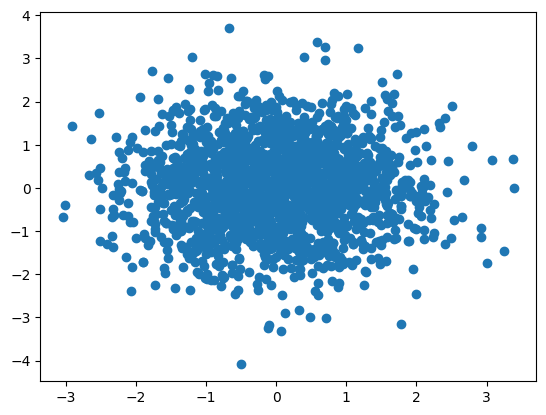

PyObject <matplotlib.collections.PathCollection object at 0x0000000001000A90>

In [17]:
scatter(samples[1, :], samples[2, :])